In [33]:
%load_ext cython

In [34]:
import numpy as np
from numpy.random import rand, randint
from PIL import Image
from ipywidgets import interact

## Define display functions

In [35]:
def lattice_to_image(lattice):
    return Image.fromarray(np.uint8((np.array(lattice) + 1)* 0.5 *255))

def display_ising(images):
    def _show(step=(0, len(images) - 1)):
        return lattice_to_image(images[step])
    return interact(_show)

# Define Ising Spin Lattice

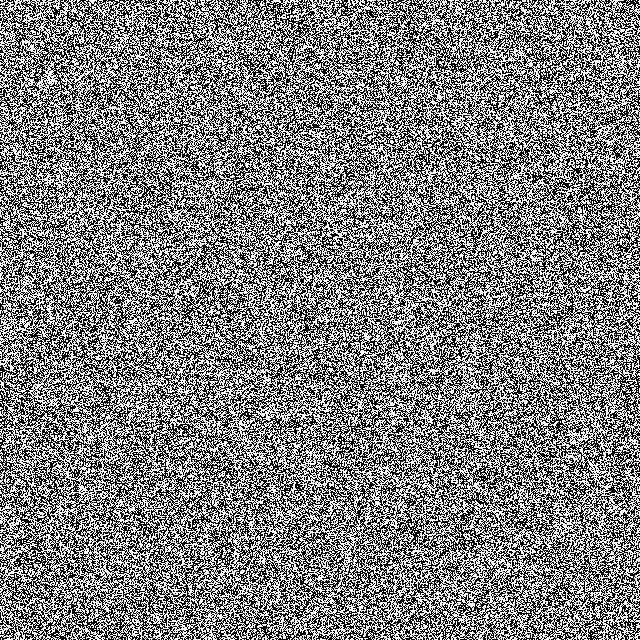

In [36]:
def random_spin_lattice(width, height):
    return np.array(2*np.round(rand(width, height)) - 1, dtype=np.int32)

def hot_spin_lattice(width, height):
    return np.array(np.ones((width, height)), dtype=np.int32)

def cold_spin_lattice(width, height):
    return np.array(-np.ones((width, height)), dtype=np.int32)

lattice_to_image(random_spin_lattice(640, 640))

# Define Monte Carlo algorithm (Metropolis)

In [40]:
%%cython -a

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp, log2
from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int RAND_MAX

DEF SIZE_4 = 4

@cython.boundscheck(False)
@cython.wraparound(False)
cdef long int _int_sum(int[] int_arr, int size):
    cdef:
        long int total = 0
        int i

    for i in range(size):
        total += int_arr[i]

    return total

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
def monte_carlo_step(int[:,:] lattice, int monte_carlo_steps, float beta, float spinCoupling, float magneticMoment, float magneticFieldStrength):
    cdef:
         int width = lattice.shape[0]
         int height = lattice.shape[1]
         np.ndarray flipped_spins = np.empty((monte_carlo_steps, 2))
         int flipped_num = 0
         int mc_step
         int s_x, s_y
         float dE
         
         unsigned int i

    for mc_step in range(monte_carlo_steps):
        # Choose a random spin site;
        s_x = rand() % width
        s_y = rand() % height
        # Calculate energy contribution to the spin lattice from randomly selected site
        dE = 2*H(lattice, s_x, s_y, spinCoupling, magneticMoment, magneticFieldStrength)
        # If the energy is positive, than switching the spin will result in a drop in the total energy, so we should swap the spin.
        # Otherwise, we swap the spin with probability e^(dE/T)
        if dE > 0 or rand() < exp(dE*beta) * RAND_MAX:
            lattice[s_x, s_y] = -lattice[s_x, s_y]
            flipped_spins[flipped_num, 0] = s_x
            flipped_spins[flipped_num, 1] = s_y
            flipped_num = flipped_num + 1
            
    # Remove remaining entries with -1
    mask = (flipped_spins[:, 0] != -1)
    flipped_spins = flipped_spins[mask, :]
    # Remove repeated lattice sites
    flipped_spins = np.unique(flipped_spins, axis=0)

    cdef int x, y

    for i in range(len(flipped_spins)):
        x = flipped_spins[i, 0]
        y = flipped_spins[i, 1]
        lattice[x, y] = -lattice[x, y]

    return lattice

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
cdef float H(int[:, :] lattice, int s_x, int s_y, float J, float mu, float B):
    """
    Local hamiltonian function takes as arguments a spin lattice, a lattice point, and system parameters and outputs the contribution to the total Ising hamiltonian given by the lattice point
        H(s) = -J*(s_i * s_j) - mu*B*s_j
        where i, j are summed over nearest neighbors <i, j>, J is the interaction strength, mu is the atomic magnetic moment, and B is the strength of an external magnetic field
    """
    cdef:
        # spin value of selected lattice point
        int s_i = lattice[s_x, s_y]
        # Shape of spin lattice
        int width = lattice.shape[0]
        int height = lattice.shape[1]
        # Nearest neighbors in the frame of reference of the selected spin
        int[SIZE_4] neighbors_x = [0, 1, 0, -1]
        int[SIZE_4] neighbors_y = [1, 0, -1, 0]
        # Spin value and spin couplings of neighbors
        int[SIZE_4] neighborSpins = [0, 0, 0, 0]
        int[SIZE_4] localSpinCoupling = [0, 0, 0, 0]

        unsigned int i, j


    # Nearest neighbors in lab frame with periodic boundary conditions
    for i in range(SIZE_4):
        neighbors_x[i] = (s_x + neighbors_x[i]) % width

    for i in range(SIZE_4):
        neighbors_y[i] = (s_y + neighbors_y[i]) % height

    # Nearest neighbors spin values
    for i in range(SIZE_4):
        for j in range(SIZE_4):
            if i == j:
                neighborSpins[i] = lattice[neighbors_x[i], neighbors_y[j]]
                localSpinCoupling[i] = s_i * neighborSpins[i]


    # Calculate Hamiltonian contribution from nearest neighbors
    cdef float E = -J*_int_sum(localSpinCoupling, SIZE_4) - mu*B*_int_sum(neighborSpins, SIZE_4)

    return E

In file included from /home/oppenheimer/.local/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/oppenheimer/.local/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/oppenheimer/.local/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/oppenheimer/.cache/ipython/cython/_cython_magic_5c639d278064231746da56dcdd28b382.c:772:
/home/oppenheimer/.local/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


# Test speed per step as a function of order parameter (computational complexity)

In [15]:
# N = 512
# beta = 2/3
# J = 1
# mu = 1
# B = 0

# %timeit monte_carlo_step(random_spin_lattice(N,N), N*np.log(N), beta, J, mu, B)
# %timeit monte_carlo_step(random_spin_lattice(N,N), N*np.log2(N), beta, J, mu, B)
# %timeit monte_carlo_step(random_spin_lattice(N,N), N**2, beta, J, mu, B)

5.44 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.13 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45.7 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Ising sequence generation

In [16]:
def ising_seq(lattice, mc_steps=100, beta_i=0.4, beta_f=None, J=1, mu=1, B=0, order=None):
    if order == None:
        order == len(lattice)**2
    
    images = [lattice]

    if beta_f != None:
        beta = np.linspace(beta_i, beta_f, mc_steps)
        for i in range(mc_steps):
            prev_lattice = images[-1].copy()
            images.append(monte_carlo_step(prev_lattice, order, beta[i], J, mu, B))
    else:
        for _ in range(mc_steps):
            prev_lattice = images[-1].copy()
            images.append(monte_carlo_step(prev_lattice, order, beta_i, J, mu, B))

    return images

In [ ]:
mc_steps = int(200)
N = 512

starting_lattice = random_spin_lattice(N, N)

for beta in np.arange(0.8, 0.59, -0.1):
    print(f'beta = {beta}')
    seq = ising_seq(starting_lattice, mc_steps, beta, order=N**2)
    display_ising(seq)

In [ ]:
mc_steps = int(100)
N = 512

starting_lattice = hot_spin_lattice(N, N)

for beta in np.arange(2, 0.75, -0.25):
    print(f'beta = {beta}')
    seq = ising_seq(starting_lattice.copy(), mc_steps, beta, order=N**2)
display_ising(seq)

# Save a high-quality GIF of an ising model monte carlo simulation

In [36]:
beta_i = 0.14
beta_f = 0.11
N = 512

seq = ising_seq(random_spin_lattice(N,N), mc_steps=1000, beta_i=beta_i, beta_f=beta_f, order=N**2, B=1)
for i in range(len(seq)):
    seq[i] = lattice_to_image(seq[i])

seq[0].save('fast.gif',
               save_all = True, append_images = seq[1:],
               optimize = True, duration=10)

# Cython Tests

In [ ]:
%%cython

import cython

cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
cdef my_sum(int[] X):
    cdef:
        int total = 0
        int N = cython.sizeof(X)
        int i 

    for i in range(N):
        total += X[i]

    return total


cdef int[4] test = [1, -1, 2, 4]

print(my_sum(test))

In [ ]:
%%cython

cimport cython

from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int RAND_MAX

cdef double rand_uniform():
    return rand() / RAND_MAX

for _ in range(100):
    print(rand_uniform())